# Imports

In [74]:
import os
from platypus import NSGAII, Problem, Real, Integer, nondominated_sort, SBX, PM, GAOperator, Evaluator, run_job, Archive, Solution, nondominated, InjectedPopulation, Mutation, NSGAIII, Variator
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import path
from shapely.geometry import Polygon, shape, Point
from descartes import PolygonPatch
import pylab as pl
from shapely import affinity
import random
import copy
from joblib import Parallel, delayed
import multiprocessing
from OSGridConverter import latlong2grid, grid2latlong
import matplotlib
import EMOVis
import plotly.express as px
import seaborn


In [75]:
os.chdir('C:/Users/zacha/Documents/GitHub/plymouth-university-proj518')
print(os.getcwd())

C:\Users\zacha\Documents\GitHub\plymouth-university-proj518


## getCorners helper function
* In order to relate distance in metres to latitude/longitude, coordinates are mapped to easting/northing OS grid.
* This grid maps coordinates to 10x10m resolution, allowing metre distance offset to be calculated, then converted back into latitude/longitude. 

In [76]:
def getCorners(lon, lat, turbnum):

    lonRads = np.radians(lon)
    latRads = np.radians(lat)

    # square root turbnum to get number of turbines along lon / lat dimensions
    length_turbnum = np.sqrt(turbnum)

    # N turbines * 500m radius, into km 
    distance = int(length_turbnum * 0.5)

    corners = []

    for bearing in [45, 135, 225, 315]:
        bearingRads = np.radians(bearing)

        maxLatRads = np.arcsin(np.sin(latRads) * np.cos(distance / 6371) + np.cos(latRads) * np.sin(distance / 6371) * np.cos(bearingRads))
        maxLonRads = lonRads + np.arctan2(np.sin(bearingRads) * np.sin(distance / 6371) * np.cos(latRads), np.cos(distance / 6371) - np.sin(latRads) * np.sin(maxLatRads))

        maxLat = np.degrees(maxLatRads)
        maxLon = np.degrees(maxLonRads)

        corners.append([maxLon, maxLat])

    """
    grid = latlong2grid(lat, lon)
    easting, northing = grid.eastNorth()

    # square root turbnum to get number of turbines along lon / lat dimensions
    length_turbnum = np.sqrt(turbnum)

    # length of lon / lat dimensions from 500m radius / turbine in metres
    # divide by 10.0 to get northing/easting conversion to 10x10m national grid = 50.0
    eastNorth_offset = int(length_turbnum * 50.0)

    # calculate easting northings of corners
    q1_easting, q1_northing = easting - eastNorth_offset, northing + eastNorth_offset
    q2_easting, q2_northing = easting + eastNorth_offset, northing + eastNorth_offset
    q3_easting, q3_northing = easting + eastNorth_offset, northing - eastNorth_offset
    q4_easting, q4_northing = easting - eastNorth_offset, northing - eastNorth_offset

    # calculate lons and lats of corners
    q1 = grid2latlong(f'TB {str(q1_easting)[1:]} {str(q1_northing)[1:]}', tag='WGS84')
    q2 = grid2latlong(f'TB {str(q2_easting)[1:]} {str(q2_northing)[1:]}', tag='WGS84')
    q3 = grid2latlong(f'TB {str(q3_easting)[1:]} {str(q3_northing)[1:]}', tag='WGS84')
    q4 = grid2latlong(f'TB {str(q4_easting)[1:]} {str(q4_northing)[1:]}', tag='WGS84')

    q1_lon, q1_lat = q1.longitude, q1.latitude
    q2_lon, q2_lat = q2.longitude, q2.latitude
    q3_lon, q3_lat = q3.longitude, q3.latitude
    q4_lon, q4_lat = q4.longitude, q4.latitude

    # calculate offsets from centre
    q1_lon_offset = q1_lon - lon
    q1_lat_offset = q1_lat - lat
    q2_lon_offset = q2_lon - lon
    q2_lat_offset = q2_lat - lat
    q3_lon_offset = q3_lon - lon
    q3_lat_offset = q3_lat - lat
    q4_lon_offset = q4_lon - lon
    q4_lat_offset = q4_lat - lat

    return q1_lon_offset, q1_lat_offset, q2_lon_offset, q2_lat_offset, q3_lon_offset, q3_lat_offset, q4_lon_offset, q4_lat_offset
    """

    return corners

# OWF

## Problem definition

In [77]:
class OWF(Problem):
    def __init__(self, lon_limits, lat_limits, day_limits, turbnum_limits, data, map_polygon, wrecks_and_obstructions, shipping_density):
        """Locate optimal location (lat and long) in an area, to maximise
        Nvars: 11 (rotation of shape, lat/long center coordinates, 4 sets of lat/long offsets from center to define corners)
        """
        super(OWF, self).__init__(4, 4, 2)

        self.lat_limits = lat_limits
        self.lon_limits = lon_limits
        self.day_limits = day_limits
        self.turbnum_limits = turbnum_limits

        self.data = data
        self.map_polygon = map_polygon
        self.wrecks_and_obstructions = wrecks_and_obstructions
        self.shipping_density = shipping_density

        #lat_range = lat_limits[1] - lat_limits[0]
        #lon_range = lon_limits[1] - lon_limits[0]

        # experimentally defined site size limitations
        #lat_range = lon_range = 0.007201325686340829
        #lon_range = 5.203365643890723e-07

        # only predict locations within the site boundaries
        # allow predictions to be Real numbers (i.e. floats)
        self.types[:] = [
            # polygon is rotated by rotation angle
            Real(0, 360),

            # center of site
            Real(self.lon_limits[0], self.lon_limits[1]),  # center lat
            Real(self.lat_limits[0], self.lat_limits[1]),  # center lon

            Integer(self.turbnum_limits[0], self.turbnum_limits[1]) # number of turbines as analogy for area of farm
        ]

        self.directions[:] = [
            Problem.MINIMIZE,   # minimise inverse of Velocity Potential (i.e. maximise Velocity Potential)
            Problem.MINIMIZE,   # minimise inverse of velocity potential density (i.e. maximise velocity potential density)
            Problem.MINIMIZE,   # minimise shipping density at solution
            Problem.MINIMIZE,   # minimise wrecks and obstructions within solution
        ]

        self.constraints[:] = [
           "==1.0",  # constrain valid shapes to have 100% intersection with site boundary
           ">-40",   # contrain depth of site to max. 40m (invert bc depth goes -inf -> 0)
        ]

        self.parameter_testing = {} # for storing parameters altered during testing and identifying solution ranks

    def evaluate(self, solution, verbose=False):
        """Evaluate variables of solution to determine fitness.

        Solution variables contain the following:
            rotation: rotation of the polygon about the center point.

            center_lat: latitude of the center point.
            center_lon: longitude of the center point.
        """

        x = solution.variables[:]

        # read solution into variables
        rotation = x[0]
        center = lon, lat = x[1:3]
        turbnum = x[3]

        q1_coord, q2_coord, q3_coord, q4_coord = getCorners(lon, lat, turbnum)   

        def rotate(points, origin, angle):
            xy = (points - origin) * np.exp(complex(0, angle)) + origin
            return xy.real, xy.imag
        
        q1_coord = rotate(complex(q1_coord[0], q1_coord[1]), complex(lon, lat), np.deg2rad(rotation))
        q2_coord = rotate(complex(q2_coord[0], q2_coord[1]), complex(lon, lat), np.deg2rad(rotation))
        q3_coord = rotate(complex(q3_coord[0], q3_coord[1]), complex(lon, lat), np.deg2rad(rotation))
        q4_coord = rotate(complex(q4_coord[0], q4_coord[1]), complex(lon, lat), np.deg2rad(rotation))

        points = np.array([q1_coord, q2_coord, q3_coord, q4_coord])
        shapely_polygon = Polygon(points)

        intersection = shapely_polygon.intersection(self.map_polygon)

        if intersection.area > 0.4 and self.map_polygon.contains(Point(lon, lat)):
            target = shapely_polygon.area
            maxR = pow(target/3.141593, 0.5)
            tolerance = 0.00001
            lower_bound = 0.0001
            outer_limit, inner_limit = 20, 20 # max number of iterations for outer and inner loops before giving up
            outer_count = 0
            
            # iterate till area outside of map polygon is less than lower bound (redistributed back inside polygon)
            while True:
                if 1 - (intersection.area / shapely_polygon.area) > lower_bound:
                    
                    low, high = 0, maxR

                    while True:
                        middle=0.5*(low+high)
                        
                        newPolygon = intersection.buffer(middle)
                        
                        if (high-low) < tolerance:
                            break
                        
                        if newPolygon.area < target:
                            low = middle
                        else:
                            high = middle

                    shapely_polygon = newPolygon
                    
                else:
                    points = np.array(shapely_polygon.exterior.coords)   # exit once difference is empty or below lower bound
                    break

                outer_count += 1
                if outer_count > outer_limit:
                    points = np.array(shapely_polygon.exterior.coords)
                    break
            
                intersection = shapely_polygon.intersection(self.map_polygon)

        # use deformed points to create new polygon for data extraction
        polygon = path.Path(points)

        # get bathymetryic and velocity potential data within polygon
        data_polygon = self.data[
            polygon.contains_points(self.data[["Lon", "Lat"]].values)
        ]

        # dataframe is empty, because no data at that location (out of bounds / too small)
        if data_polygon.empty:
            depth = -np.inf
            velocity_potential_mean = np.inf
            velocity_potential_stability = np.inf
        else:
            # get max depth from bathymetric data polygon (negatives, so find min)
            # with contraints, ensure turbines can be placed in any section of area
            depth = data_polygon["Depth"].min()

            velocity_potential = data_polygon.drop(['Lon', 'Lat', 'Depth'], axis=1)

            velocity_potential_stability = velocity_potential.std(axis=1).mean()

            velocity_potential_mean = velocity_potential.mean(axis=1).mean()

        # get all wrecks and obstructions within polygon
        wrecks_and_obstructions = self.wrecks_and_obstructions[
            polygon.contains_points(self.wrecks_and_obstructions[["longitude", "latitude"]].values)
        ]
        # fitness is number of wrecks or obstructions inside polygon (less is better)
        wrecks_and_obstructions = len(wrecks_and_obstructions)

        # get shipping density by locating density polygon which contains center point
        shipping_densities = []
        for i, row in self.shipping_density.iterrows():
            # test if center is within row['polygon']
            if row['polygon'].contains_point(center):
                # contribution of shipping density per grid square is based on intersection with that grid square
                shipping_polygon_intersection = shapely_polygon.intersection(row['shapely_polygon']).area / shapely_polygon.area
                shipping_densities.append(row['yearly_avg']*shipping_polygon_intersection)
        
        # catch out of bounds errors
        if len(shipping_densities) == 0:
            shipping_density = np.inf
        else:
            shipping_density = np.mean(shipping_densities)

        # calculate intersection area between map polygon and solution polygon
        intersection = shapely_polygon.intersection(self.map_polygon).area / shapely_polygon.area        

        solution.objectives[:] = [
            -velocity_potential_mean,   # negate to maximise
            velocity_potential_stability,
            shipping_density,
            wrecks_and_obstructions,
        ]
        
        solution.constraints[:] = [
            intersection,
            depth,
        ]


# Data

## Uk east coast velocity potential and bathymetry data

In [78]:
data = pd.read_csv("data/UK east coast velocity potential bathymetry.csv")

# NOTE: experimentally defined, enclosing area of map with depth >40m
lat_range = (53.486257927, 54.1)
lon_range = (0.5, 2.5571098)
days_range = (0, 228)

print(f"Latitude range: {lat_range}, Longitude range: {lon_range}")

print(data.head())

Latitude range: (53.486257927, 54.1), Longitude range: (0.5, 2.5571098)
        Lon        Lat          0          1          2          3          4  \
0  0.908810  53.508833 -4888854.5 -2964274.8 -1966400.0 -1944809.2 -322963.75   
1  0.982291  53.615490 -4988734.5 -3007930.2 -2047237.6 -2029393.5 -354367.40   
2  0.827796  53.586244 -4784387.0 -2952906.5 -1962346.2 -1973532.0 -356079.72   
3  0.837720  53.702704 -4801098.0 -2978041.2 -2017788.0 -2047978.2 -395331.00   
4  1.000396  53.708305 -5014005.5 -3031230.2 -2096183.8 -2092127.0 -384673.72   

           5          6          7  ...        220        221        222  \
0  1918140.2  2201700.2  497169.94  ...  3623697.0  3458370.5  3322026.8   
1  1893077.1  2230719.8  457650.47  ...  3645998.0  3475556.8  3341163.8   
2  1899125.8  2204834.5  470712.70  ...  3644461.0  3473458.5  3349537.8   
3  1871085.8  2224391.5  432494.90  ...  3669871.5  3497450.5  3374911.8   
4  1869927.0  2249043.0  425658.60  ...  3665922.8  3491546.0

## UK east coast edge points alpha 17.5 data

In [79]:
# read map polygon coords and create polygon
polygon_df = pd.read_csv("data/UK east coast edge points alpha 17.5.csv")
polygon_np = polygon_df.to_numpy()

map_polygon = Polygon(polygon_np)


## UK east coast wrecks and obstructions

In [80]:
wrecks_and_obstructions = pd.read_csv("data/UK east coast wrecks and obstructions.csv")

## UK east coast shipping density (2015)

In [81]:
shipping_density = pd.read_csv("data/UK east coast shipping density 2015.csv")

shipping_density['corner'] = shipping_density['polygon'].apply(lambda x: eval(x)[0])    # get first corner of polygon
shipping_density['shapely_polygon'] = shipping_density['polygon'].apply(lambda x: Polygon(eval(x)))   # convert polygon to shapely polygon
shipping_density['polygon'] = shipping_density['polygon'].apply(lambda x: path.Path(eval(x)))   # convert polygon to matplotlib path

## UK east coast wind energy locations
* Rotation of known sites is optimised, on assumption real site will optimally use surrounding resources similarly.


In [82]:
known_owf_locations = pd.read_csv("data/UK east coast optimised wind known energy locations.csv")

turbnum_range = (165, 174)  # min max turbnums in known truthes

print(f"Turbnum range: {turbnum_range}")

Turbnum range: (165, 174)


## UKHO ADMIRALTY bathymetry UK east coast

In [83]:
file = 'data/UKHO ADMIRALTY bathymetry UK east coast.csv'
admiralty_df = pd.read_csv(file, sep=',')
admiralty_df = admiralty_df[admiralty_df['Depth'] > -40]

## UK east coast velocity potential mean

In [84]:
mean_velocity_potential = pd.read_csv('data/UK east coast velocity potential mean.csv', sep=',')

## UK east coast velocity potential std

In [85]:
velocity_potential_stability = pd.read_csv('data/UK east coast velocity potential std.csv', sep=',')

## Data visualisation

c:\Users\zacha\miniconda3\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


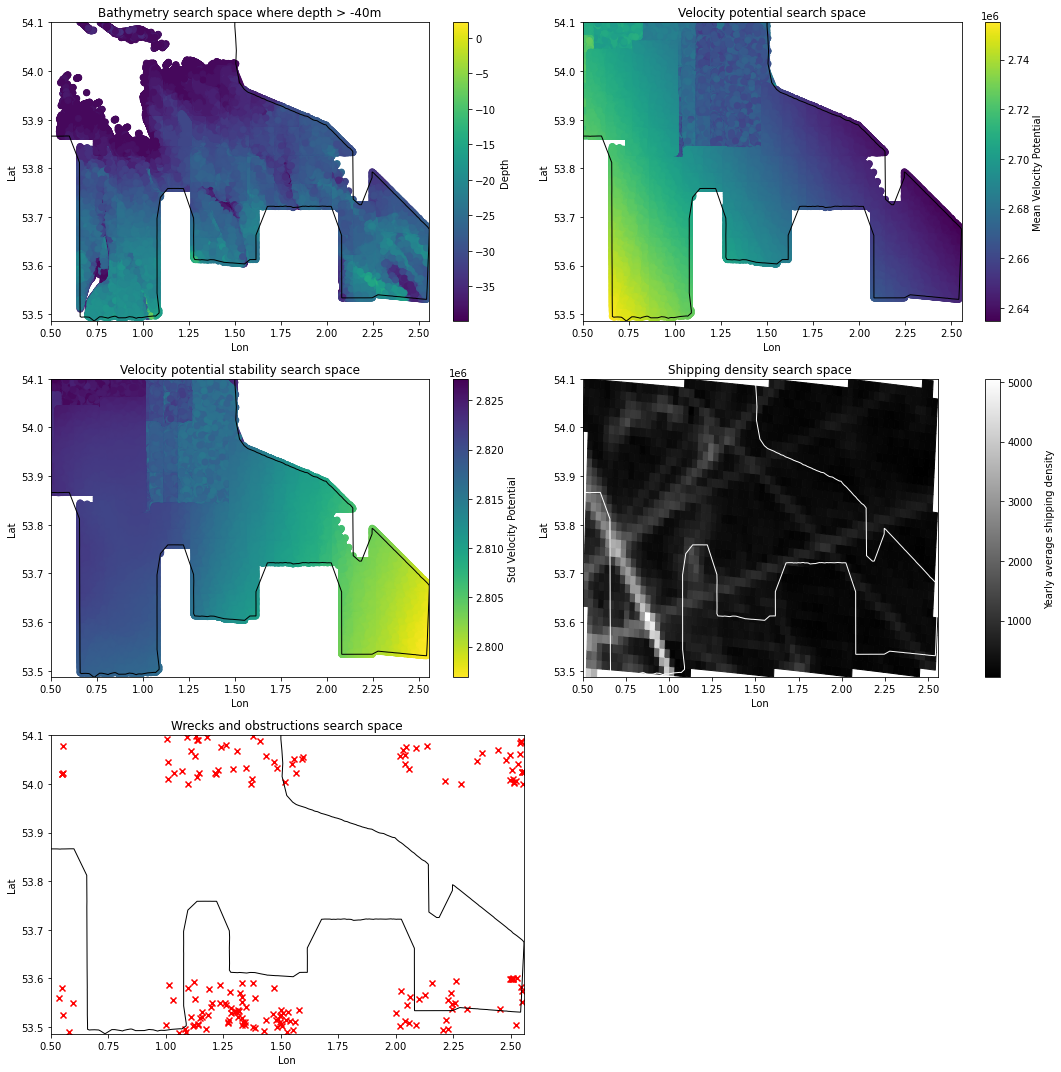

In [86]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

# BATHYMETRY
ax = axes[0, 0]
ax.set_title("Bathymetry search space where depth > -40m")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
map = ax.scatter(admiralty_df["Lon"], admiralty_df["Lat"], c=admiralty_df["Depth"], cmap="viridis")
ax.add_patch(PolygonPatch(map_polygon, fc="#999999", ec="#000000", fill=False))
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)
cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Depth')

# VELOCITY POTENTIAL
ax = axes[0, 1]
ax.set_title("Velocity potential search space")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
map = ax.scatter(mean_velocity_potential["Lon"], mean_velocity_potential["Lat"], c=mean_velocity_potential["Mean Velocity Potential"], cmap="viridis")
ax.add_patch(PolygonPatch(map_polygon, fc="#999999", ec="#000000", fill=False))
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)
cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Mean Velocity Potential')

# VELOCITY POTENTIAL STABILITY
ax = axes[1, 0]
ax.set_title("Velocity potential stability search space")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
map = ax.scatter(velocity_potential_stability["Lon"], velocity_potential_stability["Lat"], c=velocity_potential_stability["Std Velocity Potential"], cmap="viridis_r")
ax.add_patch(PolygonPatch(map_polygon, fc="#999999", ec="#000000", fill=False))
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)
cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Std Velocity Potential')

# WRECKS AND OBSTRUCTIONS
ax = axes[2, 0]
ax.set_title("Wrecks and obstructions search space")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.scatter(wrecks_and_obstructions["longitude"], wrecks_and_obstructions["latitude"], c='red', marker='x')
ax.add_patch(PolygonPatch(map_polygon, fc="#999999", ec="#000000", fill=False))
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)

# SHIPPING DENSITY
ax = axes[1, 1]
ax.set_title("Shipping density search space")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
minc, maxc = shipping_density['yearly_avg'].min(), shipping_density['yearly_avg'].max()
# calculate steps between min and max
diff = (maxc - minc)
for idx, row in shipping_density.iterrows():
    polygon = row['shapely_polygon']

    # get percentage colours[idx] is between min and max
    i = (row['yearly_avg'] - minc) / diff
    rgb = (int(255 * i), int(255 * i), int(255 * i))
    html = "#%02x%02x%02x" % rgb

    patch = PolygonPatch(polygon, fc=html, ec=html, fill=True)
    ax.add_patch(patch)
ax.add_patch(PolygonPatch(map_polygon, fc="#000000", ec="#ffffff", fill=False))
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)
cmap = matplotlib.cm.binary_r
norm = matplotlib.colors.Normalize(vmin=shipping_density['yearly_avg'].min(), vmax=shipping_density['yearly_avg'].max())
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, pad=0.1)
cbar.set_label('Yearly average shipping density', labelpad=12.0)

# remove empty subplot
fig.delaxes(axes[2, 1])

plt.tight_layout()
plt.show()

# Optimisation

In [87]:
# load the problem
problem = OWF(
    lat_limits=lat_range,
    lon_limits=lon_range,
    day_limits=days_range,
    turbnum_limits=turbnum_range,
    data=data,
    map_polygon=map_polygon,
    wrecks_and_obstructions=wrecks_and_obstructions,
    shipping_density=shipping_density,
)

## Evaluate known solutions

In [88]:
class SelectorSkip(object):
    
    def __init__(self):
        super(SelectorSkip, self).__init__()
        
    def select(self, n, population):
        # handle case where population == number of parents (2)
        assert len(population) == n
        return population
    

In [89]:
class GASkip(Variator):
    # skip GA mutation/crossover process
    
    def __init__(self):
        super(GASkip, self).__init__(0)

    def evolve(self, parents):
        children = []
        for parent in parents:
            child = copy.deepcopy(parent)
            children.append(child)
        return children

In [90]:
known_owf_solutions = []

for i, row in known_owf_locations.iterrows():
    sol = Solution(problem)
    turbnum = problem.types[3].encode(row["turbnum"])
    sol.variables = [row['rotation'], row['center_lon'], row['center_lat'], turbnum]
    known_owf_solutions.append(sol)

known_optimiser = NSGAII(problem, population_size=2, generator=InjectedPopulation(known_owf_solutions), selector=SelectorSkip(), variator=GASkip())
known_optimiser.run(1)

known_solutions = known_optimiser.result
known_solutions

[Solution[49.0,1.422626,53.681258,[True, True, False, True]|-2690311.7275937963,2814096.34233965,52.433039991283266,0|24.000660347394195],
 Solution[247.0,1.541901,53.959745,[False, False, False, False]|-2662278.173990008,2815641.652108628,10.534137064938976,1|0.4239058655696408]]

In [91]:
# unpack known_solutions into dataframe
known_solutions_df = pd.DataFrame(
    columns=[
        "rotation",
        "center_lon",
        "center_lat",
        "turbnum",
        "Velocity Potential",
        "Stability",
        "Shipping Density",
        "Wrecks and Obstructions",
        "depth",
        "Rank",
        "Marker",
    ]
)

markers = ["o", "v", "^", ">", "<", "s", "p", "P", "*", "h", "H", "D", "d", "X", "x", "1", "2", "3", "4", "8"]

nondominated_sort(known_solutions)

for i, solution in enumerate(known_solutions):
    decision_vars = []
    decoders = problem.types
    for i, var in enumerate(solution.variables):
        decoder = decoders[i]
        decision_vars += [
            decoder.decode(var),
        ]
    
    # mark relative to integer of rank
    marker = markers[int(solution.rank)]

    depth = solution.constraints[1]

    known_solutions_df.loc[len(known_solutions_df.index)] = [*decision_vars, *solution.objectives, depth, solution.rank, marker]

known_solutions_df

,rotation,center_lon,center_lat,turbnum,Velocity Potential,Stability,Shipping Density,Wrecks and Obstructions,depth,Rank,Marker
0,49.0,1.422626,53.681258,174,-2.690312e+06,2.814096e+06,52.433040,0,-64.0,1,v
1,247.0,1.541901,53.959745,165,-2.662278e+06,2.815642e+06,10.534137,1,-39.7,0,o


## Optimise new solutions

In [92]:
algorithm = NSGAIII(problem, variator=GAOperator(SBX(), PM()), divisions_outer=12)
algorithm.run(10000)


c:\Users\zacha\miniconda3\lib\site-packages\platypus\core.py:1108: RuntimeWarning: invalid value encountered in double_scalars
  sorted_solutions[j].crowding_distance += diff / (max_value - min_value)
c:\Users\zacha\miniconda3\lib\site-packages\platypus\tools.py:101: RuntimeWarning: invalid value encountered in double_scalars
  alpha = A[i][p] / A[p][p]


In [93]:
# get feasible and nondominated solutions
feasible_solutions = [s for s in algorithm.result if s.feasible]
print(f"Feasible solutions: {len(feasible_solutions)}")

nondominated(feasible_solutions)

# convert results to pandas dataframe
results = pd.DataFrame(
    columns=[
        "rotation",
        "center_lon",
        "center_lat",
        "turbnum",
        "Velocity Potential",
        "Stability",
        "Shipping Density",
        "Wrecks and Obstructions",
        "depth",
    ]
)

# read nondominated solutions into dataframe
for i, solution in enumerate(feasible_solutions):
    decision_vars = []
    decoders = problem.types
    for i, var in enumerate(solution.variables):
        decoder = decoders[i]
        decision_vars += [
            decoder.decode(var),
        ]
    depth = solution.constraints[1]

    results.loc[len(results.index)] = [*decision_vars, *solution.objectives, depth]


Feasible solutions: 456


In [94]:
# copy the data
results_max_scaled = results.copy()

# apply normalization techniques
for column in ['Velocity Potential', 'Stability', 'Shipping Density', 'Wrecks and Obstructions']:
    column_max = results_max_scaled[column].abs().max()
    column_max = 1 if column_max == 0 else column_max
    results_max_scaled[column] = results_max_scaled[column] / column_max

# add new column "objectives sum" that sums ['Velocity Potential', 'Stability', 'Shipping Density', 'Wrecks and Obstructions']
results_max_scaled['objectives sum'] = results_max_scaled[['Velocity Potential', 'Stability', 'Shipping Density', 'Wrecks and Obstructions']].sum(axis=1)

display(results_max_scaled)

,rotation,center_lon,center_lat,turbnum,Velocity Potential,Stability,Shipping Density,Wrecks and Obstructions,depth,objectives sum
0,170.408277,2.339957,53.593803,171.0,-0.970267,0.992781,0.236666,0.000000,-36.0,0.259181
1,94.897555,0.959500,53.565806,169.0,-0.998421,0.999206,0.396086,0.000000,-34.0,0.396871
2,4.629922,0.942003,53.645835,171.0,-0.995859,0.999618,0.191130,0.000000,-28.5,0.194889
3,169.800473,2.170514,53.594621,171.0,-0.973141,0.993543,0.042766,0.428571,-29.0,0.491739
4,5.571904,0.931812,53.651012,168.0,-0.995890,0.999649,0.191106,0.000000,-28.3,0.194866
...,...,...,...,...,...,...,...,...,...,...
451,5.279724,2.330160,53.596962,166.0,-0.970336,0.992842,0.236649,0.000000,-36.0,0.259154
452,358.566528,2.211416,53.642401,170.0,-0.971067,0.993509,0.135943,0.000000,-28.7,0.158385
453,174.174325,2.226454,53.590604,171.0,-0.972425,0.993304,0.047346,0.571429,-27.5,0.639654
454,87.802825,2.200218,53.604626,166.0,-0.972326,0.993420,0.035118,0.142857,-28.7,0.199070


In [95]:
minimise_solutions = []

kneepoint_idx = results_max_scaled[['objectives sum']].idxmin()['objectives sum']
print(f"Knee point index: {kneepoint_idx}")

most_minismising = feasible_solutions[kneepoint_idx]
# give most minimising an identifier
setattr(most_minismising, "kneepoint", True)
minimise_solutions.append(most_minismising)

print(most_minismising.constraints)

Knee point index: 256
[1.0, -33.5]


In [96]:
# generate solution objects for known locations
for sol in known_solutions:
    setattr(sol, 'is_known', True)  # mark solution as known solution

# combine existing solutions with nondominated solutions and rank
combined_solutions = [*known_solutions, *minimise_solutions]

nondominated_sort(combined_solutions)

# convert into list of solutions for plotting
combined_results = pd.DataFrame(
    columns=[
        "rotation",
        "center_lon",
        "center_lat",
        "turbnum",
        "Velocity Potential",
        "Stability",
        "Shipping Density",
        "Wrecks and Obstructions",
        "depth",
        "Marker",
        "IsKnown",
        "Name",
    ]
)

markers = ["o", "v", "^", ">", "<", "s", "p", "P", "*", "h", "H", "D", "d", "X", "x", "1", "2", "3", "4", "8"]

# read nondominated solutions into dataframe
for i, solution in enumerate(combined_solutions):
    if hasattr(solution, 'is_known'):
        if problem.types[3].decode(solution.variables[3]) == 174:
            mark = "o"
            name = "Hornsea 1"
        else:
            mark = "v"
            name = "Hornsea 2"

        is_known = True

    elif hasattr(solution, 'kneepoint'):
        mark = "s"
        name = "Knee-point"
        is_known = False

    else:
        name = "Min-Max"
        mark = "*"
        is_known = False

    decision_vars = []
    decoders = problem.types
    for i, var in enumerate(solution.variables):
        decoder = decoders[i]
        decision_vars += [
            decoder.decode(var),
        ]

    depth = solution.constraints[1]

    if len(solution.variables) == 4:
        combined_results.loc[len(combined_results.index)] = [*decision_vars, *solution.objectives, depth, mark, is_known, name]
    else:
        # if solution has variables for corners, remove and retain only rotation and centre
        combined_results.loc[len(combined_results.index)] = [*decision_vars[0:3], *solution.objectives, depth, mark, is_known, name]

# remove solutions with an invalid value
combined_results.replace([np.inf, -np.inf], np.nan, inplace=True)
combined_results.dropna(inplace=True)

combined_results["Velocity Potential"] = -combined_results["Velocity Potential"]

# filter out duplicate rotation/lon/lat/turbnum combinations
combined_results = combined_results.drop_duplicates()

combined_results


,rotation,center_lon,center_lat,turbnum,Velocity Potential,Stability,Shipping Density,Wrecks and Obstructions,depth,Marker,IsKnown,Name
0,49.00000,1.422626,53.681258,174,2.690312e+06,2.814096e+06,52.433040,0,-64.0,o,True,Hornsea 1
1,247.00000,1.541901,53.959745,165,2.662278e+06,2.815642e+06,10.534137,1,-39.7,v,True,Hornsea 2
2,19.26948,1.638043,53.769125,165,2.670155e+06,2.812432e+06,7.179924,0,-33.5,s,False,Knee-point


In [97]:
results["Velocity Potential"] = -results["Velocity Potential"]
results

,rotation,center_lon,center_lat,turbnum,Velocity Potential,Stability,Shipping Density,Wrecks and Obstructions,depth
0,170.408277,2.339957,53.593803,171.0,2.650811e+06,2.800459e+06,37.072857,0.0,-36.0
1,94.897555,0.959500,53.565806,169.0,2.727730e+06,2.818583e+06,62.045271,0.0,-34.0
2,4.629922,0.942003,53.645835,171.0,2.720729e+06,2.819745e+06,29.939745,0.0,-28.5
3,169.800473,2.170514,53.594621,171.0,2.658663e+06,2.802608e+06,6.699084,3.0,-29.0
4,5.571904,0.931812,53.651012,168.0,2.720814e+06,2.819832e+06,29.936069,0.0,-28.3
...,...,...,...,...,...,...,...,...,...
451,5.279724,2.330160,53.596962,166.0,2.651001e+06,2.800631e+06,37.070084,0.0,-36.0
452,358.566528,2.211416,53.642401,170.0,2.652998e+06,2.802513e+06,21.294887,0.0,-28.7
453,174.174325,2.226454,53.590604,171.0,2.656709e+06,2.801935e+06,7.416590,4.0,-27.5
454,87.802825,2.200218,53.604626,166.0,2.656436e+06,2.802261e+06,5.501162,1.0,-28.7


# Pareto Visualisation


## Nondominated evolved front

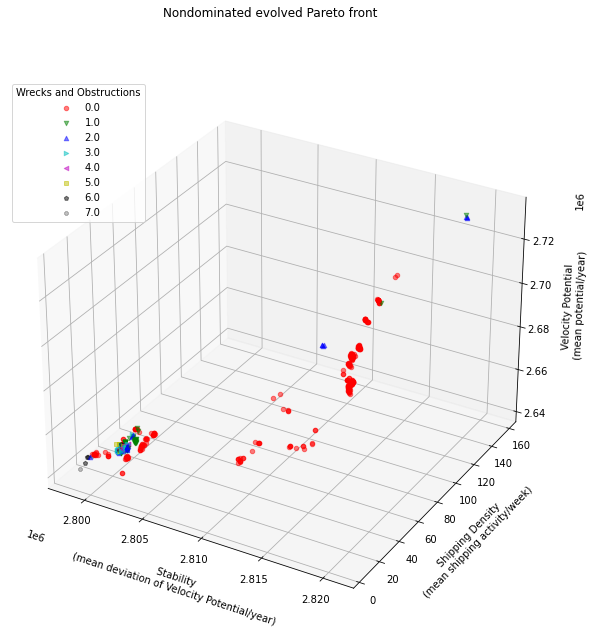

In [98]:
# Visualizing 5-D mix data using bubble charts
# leveraging the concepts of hue, marker and depth
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

t = fig.suptitle('Nondominated evolved Pareto front')

markers = ["o", "v", "^", ">", "<", "s", "p", "P", "*", "h", "H", "D", "d", "X", "x", "1", "2", "3", "4", "8"]
# list of colours to use for the markers
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'grey']

# order results by Wreck and Obstructions
results = results.sort_values(by=['Wrecks and Obstructions'])

for idx, row in results.iterrows():
    ax.scatter(row['Stability'], row['Shipping Density'], row['Velocity Potential'], label=str(row['Wrecks and Obstructions']), marker=markers[int(row['Wrecks and Obstructions'])], c=colors[int(row['Wrecks and Obstructions'])], alpha=0.5)

handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="best", title="Wrecks and Obstructions")

ax.set_xlabel('Stability \n(mean deviation of Velocity Potential/year)', labelpad=12.0)
ax.set_ylabel('Shipping Density \n(mean shipping activity/week)', labelpad=12.0)
ax.set_zlabel('Velocity Potential \n(mean potential/year)', labelpad=12.0)

#fig.savefig('exported/nondominated_evolved_pareto_front.png', dpi=300)

plt.show()

## Existing solutions vs Nondominated evolved solutions

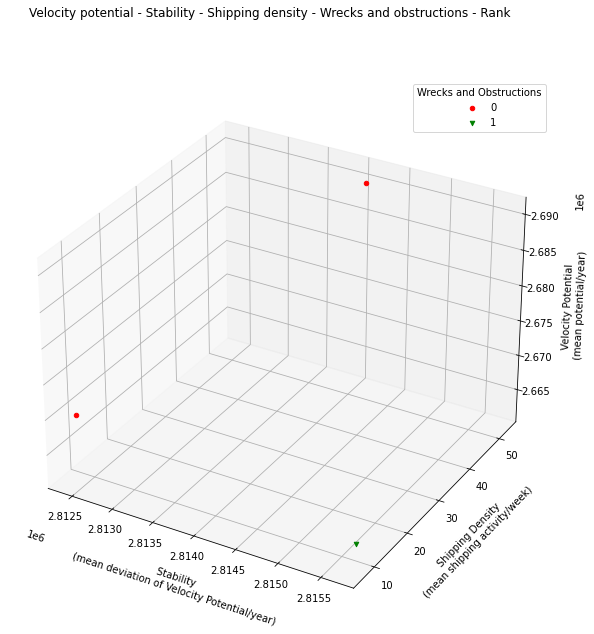

In [99]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

t = fig.suptitle('Velocity potential - Stability - Shipping density - Wrecks and obstructions - Rank')

#for idx, row in combined_results.iterrows():
#    ax.scatter(row['Stability'], row['Shipping Density'], row['Velocity Potential'], marker=row['Marker'])

markers = ["o", "v", "^", ">", "<", "s", "p", "P", "*", "h", "H", "D", "d", "X", "x", "1", "2", "3", "4", "8"]
# list of colors to use for the markers
colors = ["r", "g", "b", "c", "m", "y", "k", "w"]

for idx, row in combined_results.iterrows():
    ax.scatter(row['Stability'], row['Shipping Density'], row['Velocity Potential'], label=str(row['Wrecks and Obstructions']), marker=markers[int(row['Wrecks and Obstructions'])], c=colors[int(row['Wrecks and Obstructions'])])

handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="best", title="Wrecks and Obstructions")

ax.set_xlabel('Stability \n(mean deviation of Velocity Potential/year)', labelpad=12.0)
ax.set_ylabel('Shipping Density \n(mean shipping activity/week)', labelpad=12.0)
ax.set_zlabel('Velocity Potential \n(mean potential/year)', labelpad=12.0)

plt.show()

# Solution visualisation

### Multi-faceted visualisation
* Visualise solutions across all aspects.
* Include search space outline to provide outline for e.g.: wrecks and obstructions.

1. Bathymetric data
2. Mean velocity potential across sites
3. Shipping density
4. Wrecks/obstructions

In [100]:
boundary_patches = []

for idx, row in combined_results.iterrows():
    rotation = row['rotation']
    lon, lat = row['center_lon'], row['center_lat']
    turbnum = row['turbnum']

    q1_coord, q2_coord, q3_coord, q4_coord = getCorners(lon, lat, turbnum)    

    def rotate(points, origin, angle):
        xy = (points - origin) * np.exp(complex(0, angle)) + origin
        return xy.real, xy.imag
    
    q1_coord = rotate(complex(q1_coord[0], q1_coord[1]), complex(lon, lat), np.deg2rad(rotation))
    q2_coord = rotate(complex(q2_coord[0], q2_coord[1]), complex(lon, lat), np.deg2rad(rotation))
    q3_coord = rotate(complex(q3_coord[0], q3_coord[1]), complex(lon, lat), np.deg2rad(rotation))
    q4_coord = rotate(complex(q4_coord[0], q4_coord[1]), complex(lon, lat), np.deg2rad(rotation))

    p = np.array([q1_coord, q2_coord, q3_coord, q4_coord])
    
    polygon = Polygon(p)

    target = polygon.area
    maxR = pow(target/3.141593, 0.5)
    tolerance = 0.00001
    lower_bound = 0.0001
    outer_limit, inner_limit = 20, 20 # max number of iterations for outer and inner loops before giving up
    outer_count, inner_count = 0, 0

    # iterate till area outside of map polygon is less than lower bound (redistributed back inside polygon)
    while True:
        intersection = polygon.intersection(map_polygon)

        if 1 - (intersection.area / polygon.area) > lower_bound:
            
            low, high = 0, maxR

            inner_count = 0
            while True:
                middle=0.5*(low+high)
                
                newPolygon = intersection.buffer(middle)
                
                if (high-low) < tolerance:
                    break
                
                if newPolygon.area < target:
                    low = middle
                else:
                    high = middle

                inner_count += 1
                if inner_count > inner_limit:
                    break

            polygon = newPolygon
        else:
            break   # exit once difference is empty or below lower bound

        outer_count += 1
        if outer_count > outer_limit:
            break

    c = "#00FF00" if row['IsKnown'] == True else "#FF0000"

    boundary_patches.append((polygon, c))


#### Bathymetry

c:\Users\zacha\miniconda3\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


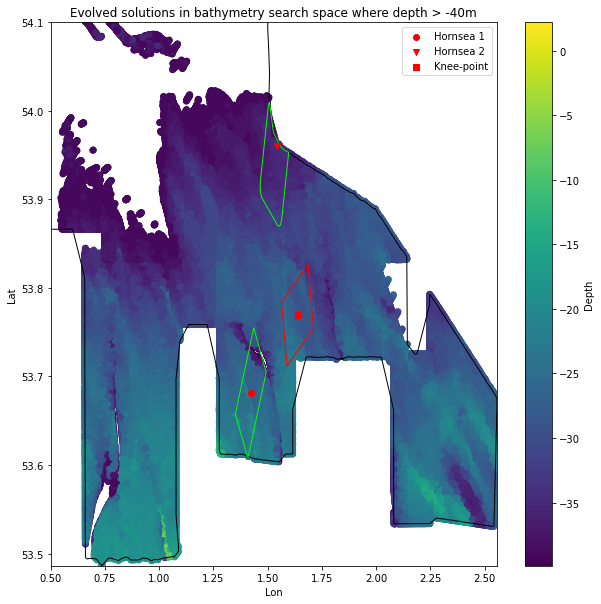

In [101]:
fig = pl.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.set_title("Evolved solutions in bathymetry search space where depth > -40m")

# load depth scatter into plot and reuse
map = ax.scatter(admiralty_df["Lon"], admiralty_df["Lat"], c=admiralty_df["Depth"], cmap="viridis")

ax.set_xlabel("Lon")
ax.set_ylabel("Lat")

map_patch = PolygonPatch(map_polygon, fc="#999999", ec="#000000", fill=False)
ax.add_patch(map_patch)

for idx, row in combined_results.iterrows():
    polygon, c = boundary_patches[idx]
    patch = PolygonPatch(polygon, fc=c, ec=c, fill=False)
    ax.add_patch(patch)
    
    ax.scatter(row['center_lon'], row['center_lat'], c='#FF0000', marker=row['Marker'], label=row["Name"])

# set axis limits to viable area
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)

handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="best")

cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Depth')

# save fig
#fig.savefig('exported/bathymetry.png', dpi=300)

plt.show()


#### Mean velocity potential

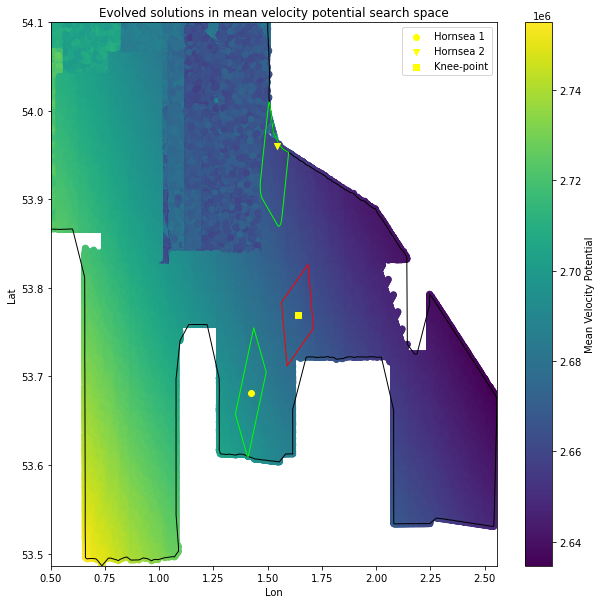

In [102]:
fig = pl.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.set_title("Evolved solutions in mean velocity potential search space")

# load depth scatter into plot and reuse
map = ax.scatter(mean_velocity_potential["Lon"], mean_velocity_potential["Lat"], c=mean_velocity_potential["Mean Velocity Potential"], cmap="viridis")

ax.set_xlabel("Lon")
ax.set_ylabel("Lat")

map_patch = PolygonPatch(map_polygon, fc="#999999", ec="#000000", fill=False)
ax.add_patch(map_patch)

for idx, row in combined_results.iterrows():
    polygon, c = boundary_patches[idx]
    patch = PolygonPatch(polygon, fc=c, ec=c, fill=False)
    ax.add_patch(patch)
    
    ax.scatter(row['center_lon'], row['center_lat'], c='#FFFF00', marker=row['Marker'], label=row['Name'])

# set axis limits to viable area
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)

handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="best")

cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Mean Velocity Potential')

# save fig
#fig.savefig('exported/mean_velocity_potential.png', dpi=300)

plt.show()


#### Velocity potential stability

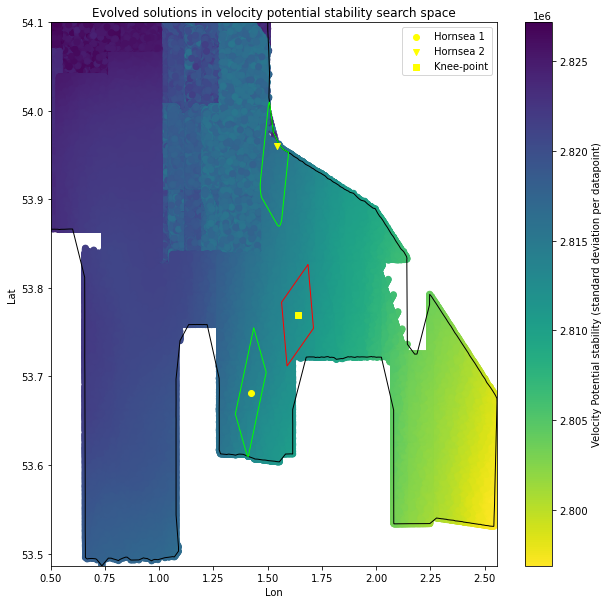

In [103]:
fig = pl.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.set_title("Evolved solutions in velocity potential stability search space")

map = ax.scatter(velocity_potential_stability["Lon"], velocity_potential_stability["Lat"], c=velocity_potential_stability["Std Velocity Potential"], cmap="viridis_r")

ax.set_xlabel("Lon")
ax.set_ylabel("Lat")

map_patch = PolygonPatch(map_polygon, fc="#999999", ec="#000000", fill=False)
ax.add_patch(map_patch)

for idx, row in combined_results.iterrows():
    polygon, c = boundary_patches[idx]
    patch = PolygonPatch(polygon, fc=c, ec=c, fill=False)
    ax.add_patch(patch)
    
    ax.scatter(row['center_lon'], row['center_lat'], c='#FFFF00', marker=row['Marker'], label=row['Name'])

# set axis limits to viable area
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)

handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="best")

cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Velocity Potential stability (standard deviation per datapoint)')

# save fig
#fig.savefig('exported/velocity_potential_stability.png', dpi=300)

plt.show()


#### Shipping density

In [104]:
minc, maxc = shipping_density['yearly_avg'].min(), shipping_density['yearly_avg'].max()
# calculate steps between min and max
diff = (maxc - minc)


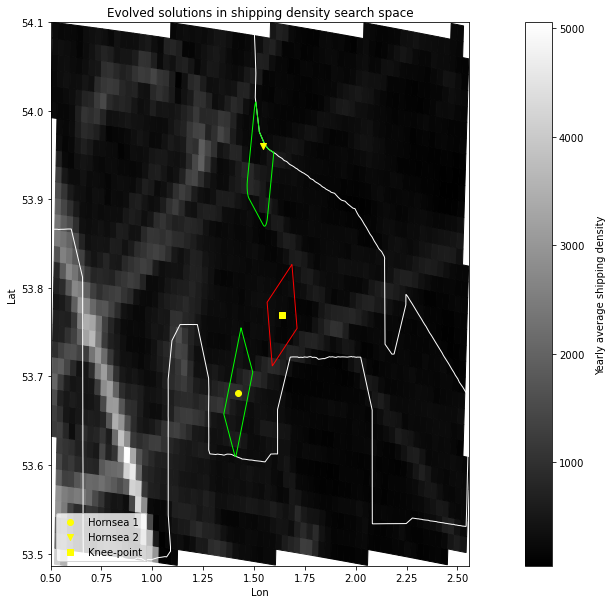

In [105]:
fig = pl.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.set_title("Evolved solutions in shipping density search space")

for idx, row in shipping_density.iterrows():
    polygon = row['shapely_polygon']

    # get percentage colours[idx] is between min and max
    i = (row['yearly_avg'] - minc) / diff
    rgb = (int(255 * i), int(255 * i), int(255 * i))
    html = "#%02x%02x%02x" % rgb

    patch = PolygonPatch(polygon, fc=html, ec=html, fill=True)
    ax.add_patch(patch)

ax.set_xlabel("Lon")
ax.set_ylabel("Lat")

map_patch = PolygonPatch(map_polygon, fc="#FFFFFF", ec="#FFFFFF", fill=False)
ax.add_patch(map_patch)

for idx, row in combined_results.iterrows():
    polygon, c = boundary_patches[idx]
    patch = PolygonPatch(polygon, fc=c, ec=c, fill=False)
    ax.add_patch(patch)
    
    ax.scatter(row['center_lon'], row['center_lat'], c='#FFFF00', marker=row['Marker'], label=row['Name'])

# set axis limits to viable area
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)

handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="best")

cmap = matplotlib.cm.binary_r
norm = matplotlib.colors.Normalize(vmin=shipping_density['yearly_avg'].min(), vmax=shipping_density['yearly_avg'].max())
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, pad=0.1)
cbar.set_label('Yearly average shipping density', labelpad=12.0)

# save fig
#fig.savefig('exported/shipping_density.png', dpi=300)

plt.show()


#### Wrecks/obstructions

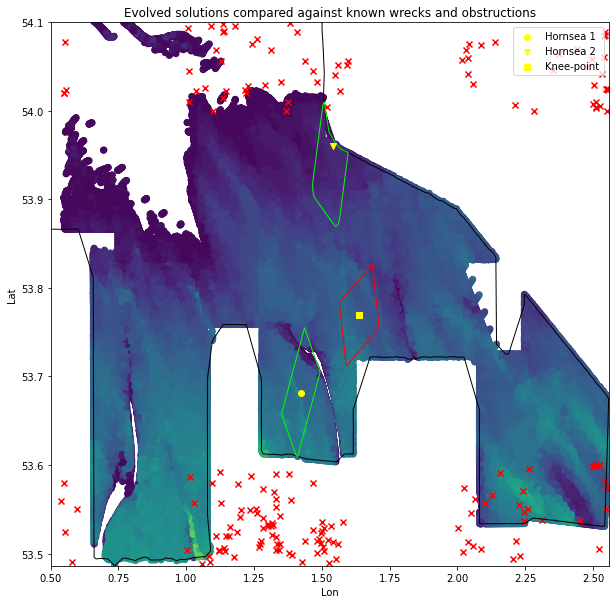

In [106]:
fig = pl.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.set_title("Evolved solutions compared against known wrecks and obstructions")

map = ax.scatter(admiralty_df["Lon"], admiralty_df["Lat"], c=admiralty_df["Depth"], cmap="viridis")

# load depth scatter into plot and reuse
ax.scatter(wrecks_and_obstructions["longitude"], wrecks_and_obstructions["latitude"], c='red', marker='x')

ax.set_xlabel("Lon")
ax.set_ylabel("Lat")

map_patch = PolygonPatch(map_polygon, fc="#999999", ec="#000000", fill=False)
ax.add_patch(map_patch)

for idx, row in combined_results.iterrows():
    polygon, c = boundary_patches[idx]
    patch = PolygonPatch(polygon, fc=c, ec=c, fill=False)
    ax.add_patch(patch)

    ax.scatter(row['center_lon'], row['center_lat'], c='#FFFF00', marker=row['Marker'], label=row['Name'])

# set axis limits to viable area
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)

handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="best")

# save fig
#fig.savefig('exported/wrecks_and_obstructions.png', dpi=300)

plt.show()


#### Boundary plots

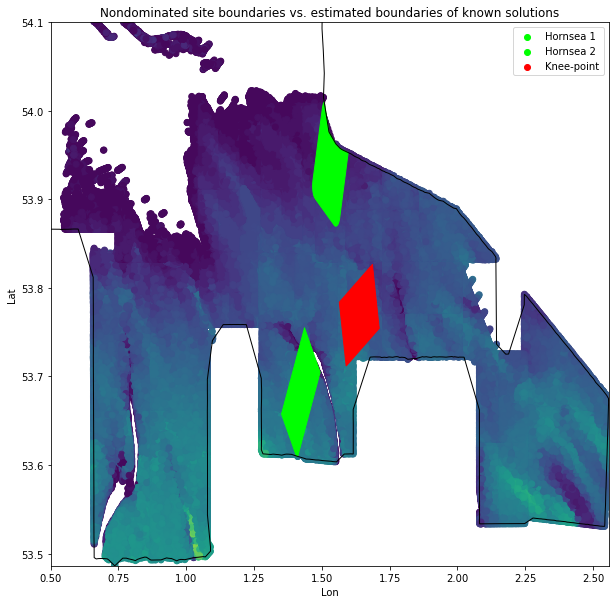

In [107]:
# plot contrained to search space
fig = pl.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.set_title("Nondominated site boundaries vs. estimated boundaries of known solutions")

ax.scatter(admiralty_df['Lon'], admiralty_df['Lat'], c=admiralty_df['Depth'], cmap='viridis')

for idx, row in combined_results.iterrows():
    rotation = row['rotation']
    lon, lat = row['center_lon'], row['center_lat']
    turbnum = row['turbnum']

    polygon, c = boundary_patches[idx]
    patch = PolygonPatch(polygon, fc=c, ec=c, fill=True)
    ax.add_patch(patch)
    
    ax.scatter(row['center_lon'], row['center_lat'], c=c, label=row['Name'], s=1)

map_patch = PolygonPatch(map_polygon, fc="#999999", ec="#000000", fill=False)
ax.add_patch(map_patch)

ax.set_xlabel('Lon')
ax.set_ylabel('Lat')

# set axis limits to viable area
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)

handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="best", markerscale=6)

# save fig
#fig.savefig('exported/boundaries.png', dpi=300)

pl.show()

#### Combined visualiations

c:\Users\zacha\miniconda3\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


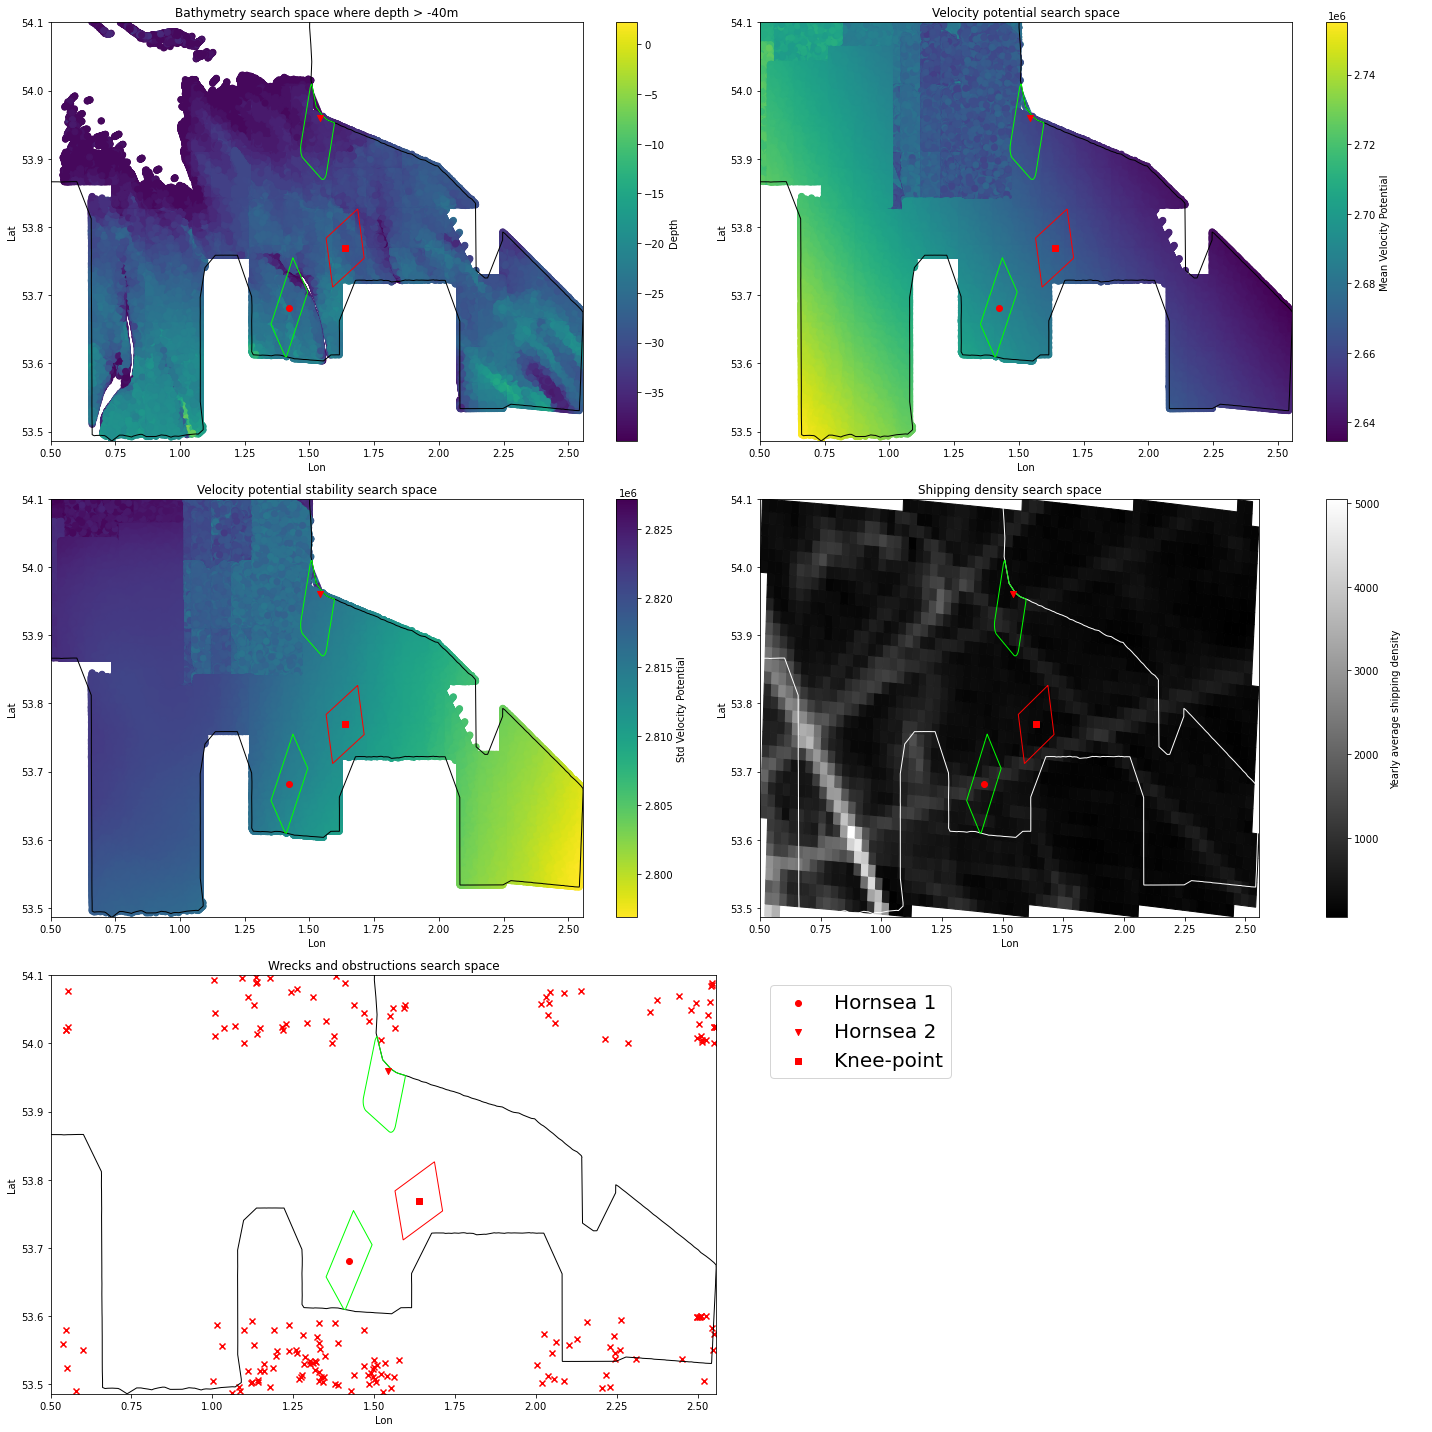

In [114]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))

# BATHYMETRY
ax = axes[0, 0]
ax.set_title("Bathymetry search space where depth > -40m")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
map = ax.scatter(admiralty_df["Lon"], admiralty_df["Lat"], c=admiralty_df["Depth"], cmap="viridis")
ax.add_patch(PolygonPatch(map_polygon, fc="#999999", ec="#000000", fill=False))
for idx, row in combined_results.iterrows():
    polygon, c = boundary_patches[idx]
    patch = PolygonPatch(polygon, fc=c, ec=c, fill=False)
    ax.add_patch(patch)
    ax.scatter(row['center_lon'], row['center_lat'], c='#FF0000', marker=row['Marker'], label=row["Name"])
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)
cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Depth')

# VELOCITY POTENTIAL
ax = axes[0, 1]
ax.set_title("Velocity potential search space")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
map = ax.scatter(mean_velocity_potential["Lon"], mean_velocity_potential["Lat"], c=mean_velocity_potential["Mean Velocity Potential"], cmap="viridis")
ax.add_patch(PolygonPatch(map_polygon, fc="#999999", ec="#000000", fill=False))
for idx, row in combined_results.iterrows():
    polygon, c = boundary_patches[idx]
    patch = PolygonPatch(polygon, fc=c, ec=c, fill=False)
    ax.add_patch(patch)
    ax.scatter(row['center_lon'], row['center_lat'], c='#FF0000', marker=row['Marker'], label=row["Name"])
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)
cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Mean Velocity Potential')

# VELOCITY POTENTIAL STABILITY
ax = axes[1, 0]
ax.set_title("Velocity potential stability search space")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
map = ax.scatter(velocity_potential_stability["Lon"], velocity_potential_stability["Lat"], c=velocity_potential_stability["Std Velocity Potential"], cmap="viridis_r")
ax.add_patch(PolygonPatch(map_polygon, fc="#999999", ec="#000000", fill=False))
for idx, row in combined_results.iterrows():
    polygon, c = boundary_patches[idx]
    patch = PolygonPatch(polygon, fc=c, ec=c, fill=False)
    ax.add_patch(patch)
    ax.scatter(row['center_lon'], row['center_lat'], c='#FF0000', marker=row['Marker'], label=row["Name"])
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)
cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Std Velocity Potential')

# SHIPPING DENSITY
ax = axes[1, 1]
ax.set_title("Shipping density search space")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
minc, maxc = shipping_density['yearly_avg'].min(), shipping_density['yearly_avg'].max()
# calculate steps between min and max
diff = (maxc - minc)
for idx, row in shipping_density.iterrows():
    polygon = row['shapely_polygon']

    # get percentage colours[idx] is between min and max
    i = (row['yearly_avg'] - minc) / diff
    rgb = (int(255 * i), int(255 * i), int(255 * i))
    html = "#%02x%02x%02x" % rgb

    patch = PolygonPatch(polygon, fc=html, ec=html, fill=True)
    ax.add_patch(patch)
ax.add_patch(PolygonPatch(map_polygon, fc="#000000", ec="#ffffff", fill=False))
for idx, row in combined_results.iterrows():
    polygon, c = boundary_patches[idx]
    patch = PolygonPatch(polygon, fc=c, ec=c, fill=False)
    ax.add_patch(patch)
    ax.scatter(row['center_lon'], row['center_lat'], c='#FF0000', marker=row['Marker'], label=row["Name"])
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)
cmap = matplotlib.cm.binary_r
norm = matplotlib.colors.Normalize(vmin=shipping_density['yearly_avg'].min(), vmax=shipping_density['yearly_avg'].max())
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, pad=0.1)
cbar.set_label('Yearly average shipping density', labelpad=12.0)

# WRECKS AND OBSTRUCTIONS
ax = axes[2, 0]
ax.set_title("Wrecks and obstructions search space")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.scatter(wrecks_and_obstructions["longitude"], wrecks_and_obstructions["latitude"], c='red', marker='x')
ax.add_patch(PolygonPatch(map_polygon, fc="#999999", ec="#000000", fill=False))
for idx, row in combined_results.iterrows():
    polygon, c = boundary_patches[idx]
    patch = PolygonPatch(polygon, fc=c, ec=c, fill=False)
    ax.add_patch(patch)
    ax.scatter(row['center_lon'], row['center_lat'], c='#FF0000', marker=row['Marker'], label=row["Name"])
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)

# empty subplot to store legend
ax = axes[2, 1]
handles, labels = axes[2, 0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="upper left", fontsize=20)
ax.axis('off')

plt.tight_layout()
plt.show()

## EMOVis

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats.stats as st
import scipy.spatial.distance as spd
import sklearn.decomposition as skd
import sklearn.manifold as skm
import matplotlib.patches as mpatches

def unpack_platypus(optimiser):
    """
    Take the Pareto front approximation from a Platypus optimiser and
    return a tuple of Numpy arrays -- one holds the decision variables and
    the other hold the objective variables.
    """
    X = np.array([soln.variables for soln in optimiser.result])
    Y = np.array([soln.objectives for soln in optimiser.result])
    return X, Y


def rank_coords(Y):
    """
    Convert the objective vectors to rank coordinates.
    """
    N, M = Y.shape
    R = np.zeros((N, M))

    for m in range(M):
        R[:,m] = st.rankdata(Y[:,m])

    return R


def rank_best_obj(Y):
    """
    Rank the given objective vectors according to the objective on which 
    they have the best rank.
    """
    R = rank_coords(Y)
    return R.argmin(axis=1).astype(np.int)


def average_rank(Y):
    """
    Rank the solutions according to their average rank score.
    """
    R = rank_coords(Y)
    return R.mean(axis=1)


def parallel_coords(Y, colours=None, cmap="viridis", xlabels=None):
    """
    Produce a parallel coordinate plot for the objective space provided.
    """
    plt.figure()
    plt.title("Parallel Coordinates Plot")
    N, M = Y.shape

    if colours is None:
        colours = ["k"] * N         # Not really ideal, needs fixing.

    objTicks = np.arange(M, dtype=np.int)
    if xlabels is None:
        xlabels = objTicks + 1
    
    for i in range(N):
        plt.plot(objTicks, Y[i], c=colours[i])

    plt.xticks(objTicks, xlabels)
    plt.xlabel("Objective")
    plt.ylabel("$f(\mathbf{x})$")

    plt.show()


def scatter_plot(Z, colours=None, cmap="viridis", title="Plot", labels=None):
    """
    Produce a scatter plot with the embedding provided.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)

    plt.title(title)
    N = Z.shape[0]

    if colours is None:
        colours = ["k"] * N         # Not really ideal, needs fixing.

    # Plot the transformed solutions.
    paths = plt.scatter(Z[:,0], Z[:,1], c=colours, cmap=cmap)

    # Tidy up the plot.
    #plt.xticks([])
    #plt.yticks([])

    plt.show()


def pca_projection(Y, colours=None, cmap="viridis", labels=None):
    """
    Project the points into two dimensions with PCA, and produce
    a corresponding plot.
    """
    # Perform the PCA projection.
    pca = skd.PCA(n_components=2)
    Z = pca.fit_transform(Y)
    scatter_plot(Z, colours=colours, cmap=cmap, title="PCA Projection", labels=labels)


def mds_projection(Y, metric="euclidean", colours=None, cmap="viridis", labels=None):
    """
    Project the points into two dimensions with MDS, and produce
    a corresponding plot. Use either Euclidean distance or dominance 
    distance.
    """
    if not metric in ["euclidean", "dominance"]:
        raise RuntimeError("Unknown metric - expected 'euclidean' or 'dominance'")

    N, M = Y.shape

    if metric == "euclidean":
        mds = skm.MDS(n_components=2)
        Z = mds.fit_transform(Y)
        
    else:
        # Compute the dominance distance.
        R = rank_coords(Y)
        D = np.zeros((N, N))
        for i in range(N):
            for j in range(N):
                D[i,j] = (1/M) * (abs(R[i] - R[j])).sum()

        mds = skm.MDS(n_components=2, dissimilarity="precomputed")
        Z = mds.fit_transform(D)

    scatter_plot(Z, colours=colours, cmap=cmap, title="MDS Projection, metric={}".format(metric), labels=labels)

### Combined results

C:\Users\zacha\AppData\Local\Temp\ipykernel_7012\3250437301.py:39: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return R.argmin(axis=1).astype(np.int)
C:\Users\zacha\AppData\Local\Temp\ipykernel_7012\3250437301.py:61: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release n

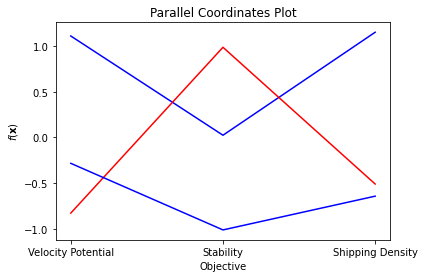

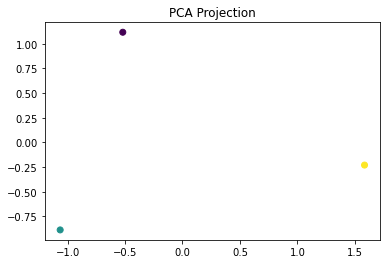

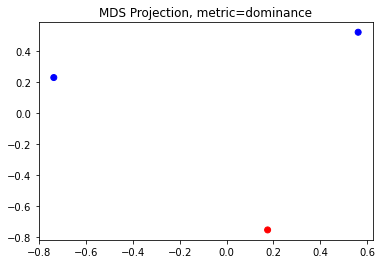

c:\Users\zacha\miniconda3\lib\site-packages\sklearn\manifold\_mds.py:517: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


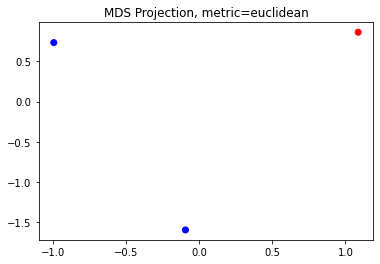

In [110]:
labels = ["Velocity Potential", "Stability", "Shipping Density"]

Y = combined_results[labels]
# mean normalise
Y = (Y - Y.mean()) / Y.std()
# convert to numpy array
Y = Y.to_numpy()

r = rank_best_obj(Y)
cols = ["rbgcmyk"[c] for c in r]
parallel_coords(Y, cols, xlabels=labels)

# Produce a PCA projection.
r = average_rank(Y) / Y.shape[0]
pca_projection(Y, colours=r, labels=labels)

# Produce a dominance-distance MDS projection.
mds_projection(Y, metric="dominance", colours=cols, labels=labels)
mds_projection(Y, metric="euclidean", colours=cols, labels=labels)

## Improvements
* Determine % improvements of evolved solutions over existing solutions.

In [111]:
improved = pd.DataFrame(
    columns=[
        "rotation",
        "center_lon",
        "center_lat",
        "turbnum",
        "depth",

        "Velocity Potential",
        "Stability",
        "Shipping Density",
        "Wrecks and Obstructions",

        "Comparison sitename",

        "Velocity Potential Change",
        "Stability Change",
        "Shipping Density Change",
        "Wrecks and Obstructions Change",

        "kneepoint",
    ]
)

# compare all solutions against hornsea1 and hornsea2
for known in known_solutions:
    sitename = "Hornsea 1" if problem.types[3].decode(known.variables[3]) == 174 else "Hornsea 2"
    known_objs = known.objectives
    known_objs[0] = 1-known_objs[0]

    for sol in minimise_solutions: 
        sol_objs = sol.objectives
        sol_objs[0] = 1-sol_objs[0]

        # get % difference between known and solution objectives
        diff = np.divide(np.subtract(known_objs, sol_objs), known_objs)
        # replace nan with 0 in diff
        diff = np.nan_to_num(diff, nan=0.0)

        # convert diff to percentage
        diff = np.multiply(diff, 100)
        # round diff to 2 decimal places
        diff = np.round(diff, 2)
        # invert diff
        diff = np.multiply(diff, -1)
        # add % symbol to diff
        diff = np.char.add(diff.astype(str), '%')
        
        decision_vars = []
        decoders = problem.types
        for i, var in enumerate(sol.variables):
            decoder = decoders[i]
            decision_vars += [
                decoder.decode(var),
            ]
        
        depth = sol.constraints[1]

        if hasattr(sol, "kneepoint"):
            kneepoint = True
        else:
            kneepoint = False

        improved.loc[len(improved.index)] = [*decision_vars, depth, *sol_objs, sitename, *diff, kneepoint]

# drop duplicate lat/lon from improved
improved = improved.drop_duplicates(subset=['center_lon', 'center_lat', 'Comparison sitename'])

C:\Users\zacha\AppData\Local\Temp\ipykernel_7012\3620955884.py:36: RuntimeWarning: invalid value encountered in true_divide
  diff = np.divide(np.subtract(known_objs, sol_objs), known_objs)


In [112]:
known_solutions_df

,rotation,center_lon,center_lat,turbnum,Velocity Potential,Stability,Shipping Density,Wrecks and Obstructions,depth,Rank,Marker
0,49.0,1.422626,53.681258,174,-2.690312e+06,2.814096e+06,52.433040,0,-64.0,1,v
1,247.0,1.541901,53.959745,165,-2.662278e+06,2.815642e+06,10.534137,1,-39.7,0,o


In [113]:
improved

,rotation,center_lon,center_lat,turbnum,depth,Velocity Potential,Stability,Shipping Density,Wrecks and Obstructions,Comparison sitename,Velocity Potential Change,Stability Change,Shipping Density Change,Wrecks and Obstructions Change,kneepoint
0,19.26948,1.638043,53.769125,165,-33.5,2.670156e+06,2.812432e+06,7.179924,0,Hornsea 1,-0.75%,-0.06%,-86.31%,-0.0%,True
1,19.26948,1.638043,53.769125,165,-33.5,-2.670155e+06,2.812432e+06,7.179924,0,Hornsea 2,-200.3%,-0.11%,-31.84%,-100.0%,True
